### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import precision_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import keras
import keras_tuner
from keras.layers import Dense, Dropout, Flatten
from keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Precision, Recall
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard
import warnings

pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')
seed = 42

%load_ext tensorboard
LOGS_DIR = 'logs_tb'

2023-04-03 00:00:30.224080: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-03 00:00:30.263458: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-03 00:00:30.264397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 00:00:30.869184: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Tensorboard can be used to debug neural networks, if desired just uncomment commented cells in this notebook
# Clear logs of previous runs
#!rm -rf LOGS_DIR

In [3]:
data = pd.read_csv('data/base_dataset.csv')

In [4]:
data.shape

(3333, 75)

### Train/CV/Test split

I'll split the data with the standard 60/20/20 split for training, cross-validation and test. Since this is not a time-series problem I can use random sampling, I'll just make sure that the target distribution is the same across the different samples, using the `stratify` option. I'll also use a fixed random_state for reproducibility.

In [5]:
X = data.drop('Churn', axis=1)
y = data['Churn']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=.2, random_state=seed, stratify=y_train)

In [7]:
y_train = np.array(y_train)
y_cv = np.array(y_cv)
y_test = np.array(y_test)

### Additional dataset processing for Neural Networks

A common approach to effectively process a dataset for modelling with a Neural Networks is to rescale the features to have zero mean and unit variance, which can be done using a StandardScaler. \
If the data had some outliers left from the previous preprocessing steps, a RobustScaler could be used instead which is not impacted by outliers as it achieves the same goal as the StandardScaler using median and interquartile ranges, instead of the more direct mean of all values. \
An additional step to increase the effectiveness of the scaling is to reduce the range of the features that have a long-tail distribution using a log transform, although this is not required in the present case.

In [8]:
scl = StandardScaler()

The scaler must be fit only on training data, to preserve the datasets separation

In [9]:
X_train = scl.fit_transform(X_train)
X_cv = scl.transform(X_cv)
X_test = scl.transform(X_test)

### Repeat the same steps for the oversampled dataset

In [10]:
data_sm = pd.read_csv('data/base_dataset_smote.csv')

X_sm = data_sm.drop('Churn', axis=1)
y_sm = data_sm['Churn']

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=.2, random_state=seed, stratify=y_sm)
X_train_sm, X_cv_sm, y_train_sm, y_cv_sm = train_test_split(X_train_sm, y_train_sm, test_size=.2, random_state=seed, stratify=y_train_sm)

y_train_sm = np.array(y_train_sm)
y_cv_sm = np.array(y_cv_sm)
y_test_sm = np.array(y_test_sm)

scl_sm = StandardScaler()

X_train_sm = scl_sm.fit_transform(X_train_sm)
X_cv_sm = scl_sm.transform(X_cv_sm)
X_test_sm = scl_sm.transform(X_test_sm)

### Build a first NN

Let's build a first fully connected Neural Network to check how it performs on the current task and have a reference value. \
There is no optimal configuration one can start with, the best approach is to test different configurations and assess the best performer. This can be tricky because NNs can be very complex and training by trial and error be very time consuming, even on a small dataset like the one at hand. \
Generally speaking, there are a few things to keep in mind:
* Three hidden layers are the minimum number demonstrated to be capable of learning any decision boundary
* Activation functions of the dense layer: relu provides the best performance at the minimum computational cost, leaky relu can be an alternative
* Activation functions of the output layer: sigmoid is used for classification problems
* Initial weigts of layers should be set carefully for the NN to converge, in particular they should not be simmetric. Luckily Keras deals with this under the hood, assigning the Glorot uniform initializer by default
* The dataset is imbalanced, applying weights to the model (that will be in the output layer) is not strictly necessary but helps converging much faster
* Vanishing/exploding gradients
* Dropout layers are a form of regularization that drops a certain percentage of the nodes at random, helping reducing variance and faster convergence
* Optimizer: Adam is stochastic gradient descent algorithm and a common choice, it controls the learning rate of the NN
* Loss: Objective function to be minimized, binary crossentropy (also log loss) is a standard function for binary classification
* Metrics: These will be calculated at runtime for each epoch, but it's the loss that drives the training
* CV: a cross validation set to assess the loss and the metrics at training time to effectively avoid overfitting. It's also important to use CV here instead of the test set, because otherwise there is the risk of overfitting to the test set, reducing the validity of the final metrics on that set  
* Early stopping: Stops the training when the selected funcion doesn't improve over a certain amount of time. This helps saving training time and overfitting
* Batch size: can be any number, but it's much faster if it's a power of 2.

In [11]:
model = keras.Sequential()
model.add(Dense(128,activation='relu'))
model.add(Dropout(.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(.3))
model.add(Dense(1,activation='sigmoid'))

metrics = ['acc', Precision(name='precision'), Recall(name='recall')]

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

callbacks = [EarlyStopping(monitor='val_loss', patience=10), TensorBoard(LOGS_DIR)]

counts = np.bincount(y_train)
w_0 = 1.0 / counts[0]
w_1 = 1.0 / counts[1]
class_weight = {0: w_0, 1: w_1}

In [12]:
%%time
history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=100,
    verbose=0,
    callbacks=callbacks,
    validation_data=(X_cv, y_cv),
    class_weight=class_weight,
    use_multiprocessing=True)

CPU times: user 6.66 s, sys: 618 ms, total: 7.28 s
Wall time: 4.43 s


In [13]:
#%tensorboard --logdir LOGS_DIR

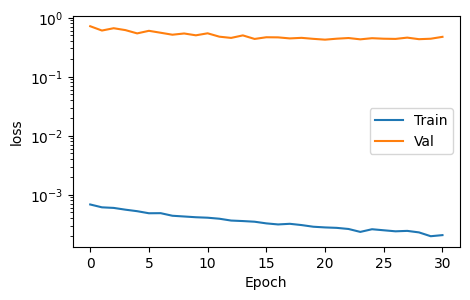

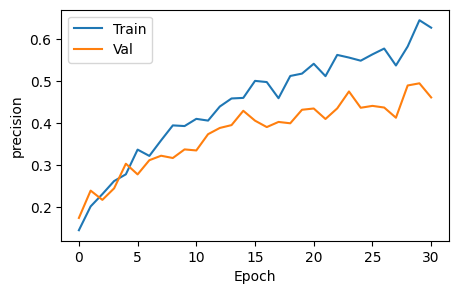

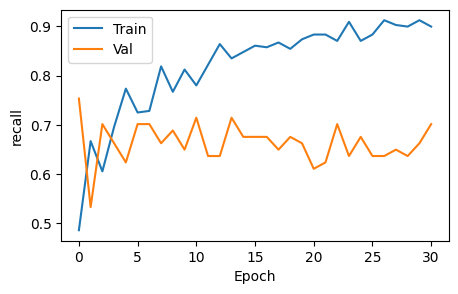

In [14]:
metric_list = ['loss', 'precision', 'recall']
for m in metric_list:
    plt.figure(figsize=(5, 3))
    plt.plot(history.epoch, history.history[m], label='Train')
    plt.plot(history.epoch, history.history['val_'+m], label='Val')
    if m == 'loss': plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel(m)
    plt.legend();

In [15]:
results = model.evaluate(X_test, y_test, batch_size=128)

6/6 [==============================] - 0s 2ms/step - loss: 0.3985 - acc: 0.8426 - precision: 0.4710 - recall: 0.6701


#### Comment

The perfomance of this NN is way below the baseline found with the Gradient Boosting Classifier. It's not learning accurately and at the same time it stops after only 35 epochs, so the first steps I would take are to increase the complexity of the network and decrease the learning rate.

### Test the same NN on the oversampled dataset

In [16]:
model_sm = keras.Sequential()
model_sm.add(Dense(128,activation='relu'))
model_sm.add(Dropout(.3))
model_sm.add(Dense(128,activation='relu'))
model_sm.add(Dropout(.3))
model_sm.add(Dense(128,activation='relu'))
model_sm.add(Dropout(.3))
model_sm.add(Dense(1,activation='sigmoid'))

metrics = ['acc', Precision(name='precision'), Recall(name='recall')]

model_sm.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

callbacks = [EarlyStopping(monitor='val_loss', patience=10), TensorBoard(LOGS_DIR)]

In [17]:
%%time
history_sm = model_sm.fit(
    X_train_sm,
    y_train_sm,
    batch_size=128,
    epochs=100,
    verbose=0,
    callbacks=callbacks,
    validation_data=(X_cv_sm, y_cv_sm),
    use_multiprocessing=True)

CPU times: user 8.79 s, sys: 758 ms, total: 9.55 s
Wall time: 5.4 s


In [18]:
#%tensorboard --logdir LOGS_DIR

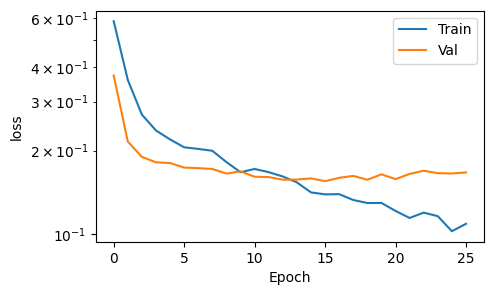

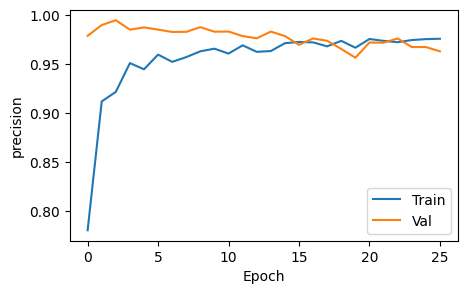

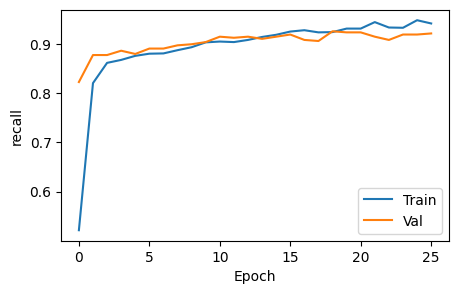

In [19]:
metric_list = ['loss', 'precision', 'recall']
for m in metric_list:
    plt.figure(figsize=(5, 3))
    plt.plot(history_sm.epoch, history_sm.history[m], label='Train')
    plt.plot(history_sm.epoch, history_sm.history['val_'+m], label='Val')
    if m == 'loss': plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel(m)
    plt.legend();

In [20]:
results = model.evaluate(X_test_sm, y_test_sm, batch_size=128)

9/9 [==============================] - 0s 2ms/step - loss: 0.4485 - acc: 0.8360 - precision: 0.9303 - recall: 0.7263


#### Comment

The same NN has much higher performance with the oversampled dataset. Still it ends training after only ~30 epochs and this is an indication that a smaller learning rate could help along with other tweaks that one can try.

### Fine tuning

The next thing to do is to change the paramters space to find the best configuration of the network. This can be done with `keras-tuner` that works similarly to RandomSearch in scikit-learn; `keras-tuner` also implements additional algorithms to search the parameters space that help optimize the run, a notable one is the Bayesian Optimizer. \
For this task, it makes sense to focus only on the best performing dataset, which is the oversampled one. \
The parameters I'll tune are the number of nodes in the Dense layers, the dropout ratio and the learning rate.

In [21]:
def build_model(hp):
    model = keras.Sequential()
    model.add(Dense(units=hp.Int('units', min_value=64, max_value=512, step=32),activation='relu',))
    model.add(Dropout(rate=hp.Float('rate', min_value=.2, max_value=.5, step=.1)))
    model.add(Dense(units=hp.Int('units', min_value=64, max_value=512, step=32),activation='relu',))
    model.add(Dropout(rate=hp.Float('rate', min_value=.2, max_value=.5, step=.1)))
    model.add(Dense(units=hp.Int('units', min_value=64, max_value=512, step=32),activation='relu',))
    model.add(Dropout(rate=hp.Float('rate', min_value=.2, max_value=.5, step=.1)))
    model.add(Dense(1, activation='sigmoid'))
    learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    metrics = ['acc', Precision(name='precision'), Recall(name='recall'), ]
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=metrics)
    return model

build_model(keras_tuner.HyperParameters());

In [22]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
)

In [23]:
callbacks=[EarlyStopping(monitor='val_loss', patience=10), TensorBoard(LOGS_DIR)]

In [24]:
%%time
tuner.search(
    X_train_sm, 
    y_train_sm, 
    epochs=100, 
    batch_size=128,
    validation_data=(X_cv_sm, y_cv_sm), 
    callbacks=callbacks, 
    class_weight=class_weight
)

Trial 50 Complete [00h 00m 07s]
val_loss: 0.20134766399860382

Best val_loss So Far: 0.16647298634052277
Total elapsed time: 00h 06m 37s
INFO:tensorflow:Oracle triggered exit
CPU times: user 19min 35s, sys: 2min 20s, total: 21min 56s
Wall time: 6min 36s


In [25]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 17 summary
Hyperparameters:
units: 416
rate: 0.4
lr: 0.0009823079430437143
Score: 0.16647298634052277

Trial 45 summary
Hyperparameters:
units: 352
rate: 0.30000000000000004
lr: 0.0001927681074827024
Score: 0.17248013615608215

Trial 41 summary
Hyperparameters:
units: 352
rate: 0.2
lr: 0.0004549298027987531
Score: 0.173091322183609

Trial 43 summary
Hyperparameters:
units: 352
rate: 0.30000000000000004
lr: 0.0007242841285133227
Score: 0.17317454516887665

Trial 14 summary
Hyperparameters:
units: 352
rate: 0.30000000000000004
lr: 0.0015335299542959195
Score: 0.1747128963470459

Trial 46 summary
Hyperparameters:
units: 288
rate: 0.4
lr: 0.0004959159233310334
Score: 0.17654474079608917

Trial 26 summary
Hyperparameters:
units: 384
rate: 0.4
lr: 0.0020190074428835113
Score: 0.17861728370189667

Trial 38 summary
Hyperparameters:
units: 448
rate: 0.4
lr: 0.00098808232842780

In [26]:
# %tensorboard --logdir LOGS_DIR

In [27]:
best_model = tuner.get_best_models()[0]

In [28]:
best_model.build(input_shape=(None, X_train_sm.shape[-1]))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 416)               31200     
                                                                 
 dropout (Dropout)           (None, 416)               0         
                                                                 
 dense_1 (Dense)             (None, 416)               173472    
                                                                 
 dropout_1 (Dropout)         (None, 416)               0         
                                                                 
 dense_2 (Dense)             (None, 416)               173472    
                                                                 
 dropout_2 (Dropout)         (None, 416)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 4

In [29]:
best_model.evaluate(X_test_sm, y_test_sm)

36/36 [==============================] - 0s 2ms/step - loss: 0.1621 - acc: 0.9421 - precision: 0.9437 - recall: 0.9404


[0.1621016412973404, 0.942105233669281, 0.9436619877815247, 0.9403508901596069]

In [30]:
y_pred_proba_sm = best_model.predict(X_test_sm)

36/36 [==============================] - 0s 2ms/step


In [31]:
y_pred_sm = (y_pred_proba_sm.flatten() >= .5).astype(int)

In [32]:
print(f'Precision: {round(precision_score(y_test_sm, y_pred_sm), 2)}')
print(f'F1-score: {round(f1_score(y_test_sm, y_pred_sm), 2)}') 

Precision: 0.94
F1-score: 0.94


#### Comment

Performing this fine tuning allowed to significantly increase the performance of the network reducing the loss of the initial trial by almost 70%, which can be done to further extent by increasing the number of trials, testing a diffenent number of layers, or performing a new search in a space near the best model parameters found.